# SMV2rho: Tutorial 7

In this tutorial we will see how we can convert multiple velocioty profiles simultaneously.

In [1]:
# import modules
import numpy as np
from SMV2rho import plotting as smplt
from SMV2rho import density_functions as smd
from SMV2rho import coincident_profile_functions as cnc
from SMV2rho import constants as c
from SMV2rho import temperature_dependence as td

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Reading files

First we need to provide a path to the master directory with all velocity profiles.  Note that at this point, the file structure becomes very important.

Here, we will import the `SeisCruST` database, which can be accessed here... https://doi.org/10.5281/zenodo.10017429

Let's first remind ourselves of the required file structure.  First replace the `path` variable in the following code block with the path to the `CRUSTAL_STRUCTURE` subdirectory within the `SeisCruST` database master directory (or the path to the velocity profiles that you wish to convert into density).  We will then draw a file tree for the database.

In [2]:
path = "../../SEISCRUST_WORKING/CRUSTAL_STRUCTURE" # path to the full velocity profile directory

# draw a file tree
smplt.draw_file_tree(path, include_files=False, 
               suppress_pycache=True, suppress_hidden=True)

CRUSTAL_STRUCTURE
|- CRUSTAL_STRUCTURE
|  |- ARABIA
|  |  |- Vs
|  |  |  `- RECEIVER_FUNCTION
|  |  |     `- DATA
|  |  |- vs_rho_stephenson
|  |  |  `- RECEIVER_FUNCTION
|  |  `- vs_rho_stephenson_T_DEPENDENT
|  |     `- RECEIVER_FUNCTION
|  |- CARIBBEAN
|  |  |- Vp
|  |  |  `- RECEIVER_FUNCTION
|  |  |     `- DATA
|  |  |- Vs
|  |  |  `- RECEIVER_FUNCTION
|  |  |     `- DATA
|  |  |- vp_rho_stephenson
|  |  |  `- RECEIVER_FUNCTION
|  |  |- vp_rho_stephenson_T_DEPENDENT
|  |  |  `- RECEIVER_FUNCTION
|  |  |- vs_rho_stephenson
|  |  |  `- RECEIVER_FUNCTION
|  |  `- vs_rho_stephenson_T_DEPENDENT
|  |     `- RECEIVER_FUNCTION
|  |- EUROPE
|  |  |- Vp
|  |  |  `- RECEIVER_FUNCTION
|  |  |     `- DATA
|  |  |- Vs
|  |  |  `- RECEIVER_FUNCTION
|  |  |     `- DATA
|  |  |- vp_rho_stephenson
|  |  |  `- RECEIVER_FUNCTION
|  |  |- vp_rho_stephenson_T_DEPENDENT
|  |  |  `- RECEIVER_FUNCTION
|  |  |- vs_rho_stephenson
|  |  |  `- RECEIVER_FUNCTION
|  |  `- vs_rho_stephenson_T_DEPENDENT
|  |     

To convert multiple profiles, we will be using the `MultiConversion` class within the density_functions module.  Before we get started, let's take a look at the docstring for the `MultiConversion` class.

In [3]:
smd.MultiConversion?

Init signature:
smd.MultiConversion(
    path,
    which_location='ALL',
    write_data=False,
    approach='stephenson',
    parameters=None,
    master_geotherm=None,
    constant_depth=None,
    constant_density=None,
    T_dependence=False,
)
Docstring:     
Wrapper class to extract multiple files from path to send to 
Convert class using specified density conversion approach.
Check that all required arguments have been provided.

Attributes:
    path (str): The master directory where all data are stored in 
        directories named after their location.
    which_location (str or list, optional): Determines which 
        locations the user wants to convert. Defaults to "ALL," 
        indicating that all locations will be converted. If specific 
        locations are desired, provide a list of location names.
    write_data (bool, optional): Specifies whether to write the 
        converted data to files. Defaults to False.
    approach (str, optional): The density conversion ap

In this case, the parameter files require both $V_P$ and $V_S$ parameters.  Previously, we have only provided parameters for wither $V_P$ or $V_S$.  Note that we need both sets of parameters even if we are only converting one type of profile.  The velocity-to-density conversion parameters should be a `np.ndarray` with two columns with $V_P$ oparameters in the first column and $V_S$ parameters in the second.  The parameters controlling temperature dependence should be organised $[m_P, m_S, \alpha_0, \alpha_1, K_c]$.

In [4]:
# create the constants object.
constants = c.Constants()

constants.get_v_constants('Vp')
constants.get_v_constants('Vs')
constants.get_material_constants()

## Creating the Geotherm list

We first need to create geotherm instances for every profile.  They will then be packaged up as a dictionary entry in the MultiConversion class so that the correct geothermal parametrisation travels with the profile of interest.  For example, this can be useful if each profile is associated with different geothermal parameters, like surface heatflow or crustal thickness etc.

In this example we will use the heat flux difference method and we will just use constant default values for every profile.  It is of course possible to enter custom values for the geothermal parameters if needed.

In [5]:
geotherm = td.Geotherm(geotherm_type='single_layer_flux_difference')

Now we will read the files using the `MultiConversion` class within the density_functions module.  We will set `which_profiles` to `'ALL'`, but note that we can set this to a location subdirectory name, for example, we could set it to `'MADAGASCAR'` is we were only interested in converting profiles from the 'MADAGASCAR' subdirectory.

Using the multiple profiles conversion functionality requires some understanding of classes, but using them is relativekly simple and doesn't need to deviate from the procedure outlined below.  We will set `write_data` to false, but this should be set to `True` if the output should be written.  If `True` is set, then new directories will be automatically created within the file system containing the outputs of the density conversion with a subdirectory heading that corresponds to the chosen method.

We will run the `stephenson` method with a constant density set in the uppermost 7 km and temperature dependence included.  If Brocher's (2005) method is preferred, then `'brocher'` should be set.  If temperature dependence is not desired then set `T_dependence = False`.  If `write_data = True`, then these options will determine the output directory heading.

In [6]:
# convert all profiles
which_profiles = 'ALL'

# set up the class instance to convert multiple profiles at once
profiles = smd.MultiConversion(
    path,
    which_location = which_profiles,
    write_data = False,
    approach = "stephenson",
    parameters = constants,
    master_geotherm = geotherm,
    constant_depth = 7,
    constant_density = 2.75,
    T_dependence = True)

## Assemble file lists

We can now assemble the necessary file paths and extract data from the files using the `assemble_file_lists` method.  We should see a list of the location subdirectories for which file lists are being assmbled.

In [7]:
# assemble necessary information to carry out conversion
#  e.g. file paths, parameters, other metadata etc.
profiles.assemble_file_lists()

ALL selected, assembling file lists for all profiles...
   -- assembling lists for WEST_TIBET
   -- assembling lists for N_ATLANTIC
   -- assembling lists for HUDSON_BAY
   -- assembling lists for SE_ASIA
   -- assembling lists for N_AFRICA
   -- assembling lists for ARABIA
   -- assembling lists for TIEN_SHAN
   -- assembling lists for CARIBBEAN
   -- assembling lists for USGS_GSC
   -- assembling lists for EUROPE
   -- assembling lists for INDIA
   -- assembling lists for S_AFRICA
   -- assembling lists for MADAGASCAR
   -- assembling lists for IRAN
   -- assembling lists for S_AMERICA
Reading in data and converting to density using stephenson approach...


This command will produce an attribute within the `Profiles` class instance called `convert_metadata`, which is a list of the metadata required to convert each individual profile into density.  Vp profiles will be assigned Vp conversion parameters etc.  Let's have a look at the `convert_metadata` entry for the first profile.

In [8]:
for i in profiles.convert_metadata[0]:
    print(i)

../../SEISCRUST_WORKING/CRUSTAL_STRUCTURE/CARIBBEAN/Vp/RECEIVER_FUNCTION/DATA/T03_LMG_Vp.dat
Vp
False
../../SEISCRUST_WORKING/CRUSTAL_STRUCTURE
stephenson
CARIBBEAN
Constants(vp_constants=VpConstants(v0=-0.93521, b=0.00169478, d0=2.55911, dp=-0.00047605, c=1.674065, k=0.01953466, m=-0.0004, v0_unc=None, b_unc=None, d0_unc=None, dp_unc=None, c_unc=None, k_unc=None, m_unc=0.0001), vs_constants=VsConstants(v0=-0.60777, b=0.0010345, d0=1.4808, dp=-0.00029773, c=0.7374, k=0.020041, m=-0.00023, v0_unc=None, b_unc=None, d0_unc=None, dp_unc=None, c_unc=None, k_unc=None, m_unc=0.0001), material_constants=MaterialConstants(alpha0=1e-05, alpha1=2.9e-08, K=90000000000.0, alpha0_unc=5e-06, alpha1_unc=5e-09, K_unc=20000000000.0))
7
2.75
True
Geotherm(tc=None, T0=10.0, T1=600.0, q0=0.059, qm=0.03, k=2.5, H0=7e-10, hr=10.0, rho=2.9)


## Convert profiles

Now we can call the `send_to_conversion_function` method, which will convert all of the profiles to density.  When this code block is run, you should see a progress bar showing how close to completion the conversion is.  Note there may be the odd integration warning.  As before, these only appear because velocity profiles can bve discontinuous, and these warnings can be safely ignored.

We will set the output of this function as a new object `station_profiles`, but all outputs will be returned to the `Profiles` object as class attributes.

In [9]:
# run density conversion for all profiles
station_profiles = profiles.send_to_conversion_function()

[                                                  ] 0%

/Users/eart0518/Work/SMV2rho/src/SMV2rho/density_functions.py:1676: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_val = integrate.quad(interp_profile, bins_low_res[e],


[                                                  ] 0%

/Users/eart0518/Work/SMV2rho/src/SMV2rho/density_functions.py:1676: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_val = integrate.quad(interp_profile, bins_low_res[e],


[==================================================] 100%

Now we can interrogate the output of the the `station_profiles` attribute of the `Profiles` object and compare it to the `station_profiles` object.  Both are identical and contain a list of individual profile dictionaries.  These dictionaries are equvalent to the profile dictionaries that we have been using in the previous tutorials.

In [10]:
print(profiles.station_profiles[0].keys())
print(station_profiles[0].keys())

dict_keys(['station', 'Vp_file', 'region', 'moho', 'location', 'av_Vp', 'Vp', 'type', 'method', 'geotherm', 'rho', 'av_rho', 'rho_hi_res', 'Vp_hi_res', 'p', 'T'])
dict_keys(['station', 'Vp_file', 'region', 'moho', 'location', 'av_Vp', 'Vp', 'type', 'method', 'geotherm', 'rho', 'av_rho', 'rho_hi_res', 'Vp_hi_res', 'p', 'T'])


## Locating coincident profiles

Now we will locate $V_P$ and $V_S$ profiles that are within a given distance of one another to check how the density conversion performs and wether crustal thickness estimates match up etc.

First we need to divide the `station_profiles` list up into two batches, in this case of Vp and Vs profiles.  Note that we can divide the `station_profiles` list in any arbitary way to make comparisons.

Next we will run the `get_coincident_profiles` function in the `coincident_profiles` module.  Running this function will print a progress report tracking how far through the station_profiles list the program has progressed.  It will return a list of stations that are in the same location as another profile given a buffer distance `buff_dist`.  This list will be organised in the same way as `station_profiles`, but will have empty entries where there are no profiles coincident with that station.

In [29]:
buff_dist = 50 # buffer distance to nearest profile

# extract vs profiles and vp profiles from station_profiles
vs_profiles = np.array(list(filter(lambda station: 
                            station['type'] == 'Vs', station_profiles)))
vp_profiles = np.array(list(filter(lambda station: 
                            station['type'] == 'Vp', station_profiles)))

# calculate coincident vp and vs profiles within buffer distance, buff
coincident_profiles, vp_profiles, vs_profiles = cnc.get_coincident_profiles(vp_profiles, vs_profiles, buff_dist)

Finding stations with coincident Vp and Vs surveys...
   -- this may take a few minutes...!
   -- taking locations < 50.0 km from vp measurement
       - currently on item 100 of 2431
       - currently on item 200 of 2431
       - currently on item 300 of 2431
       - currently on item 400 of 2431
       - currently on item 500 of 2431
       - currently on item 600 of 2431
       - currently on item 700 of 2431
       - currently on item 800 of 2431
       - currently on item 900 of 2431
       - currently on item 1000 of 2431
       - currently on item 1100 of 2431
       - currently on item 1200 of 2431
       - currently on item 1300 of 2431
       - currently on item 1400 of 2431
       - currently on item 1500 of 2431
       - currently on item 1600 of 2431
       - currently on item 1700 of 2431
       - currently on item 1800 of 2431
       - currently on item 1900 of 2431
       - currently on item 2000 of 2431
       - currently on item 2100 of 2431
       - currently on it

We can now extract bulk properties of these profiles that are located in the same place.  For example, we can compare bulk seismic velocities and moho depth etc.

In [30]:
# get some bulk crustal properties for the coincident profiles,
#  e.g. compare densities or moho depth etc.
# also return the location of coincident profiles.
vp_vs_vpcalc, rho_rho, moho_moho, lon_lat = \
    cnc.compare_adjacent_profiles(vp_profiles, coincident_profiles, approach="stephenson")

## Output and plotting

Now we can plot up the results of locating these coincident profiles.  We will again use some functionality from the `plotting` module in `SMV2rho`.  

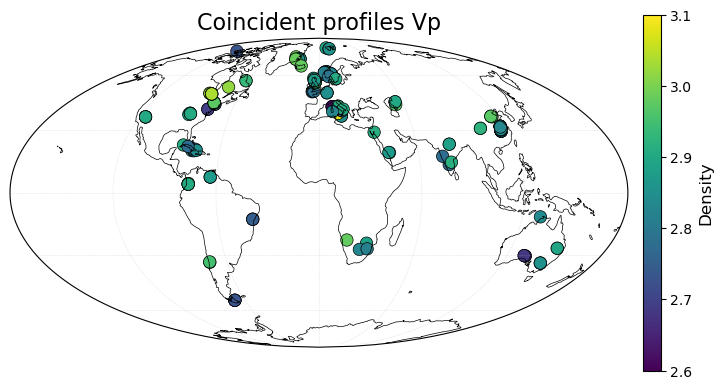

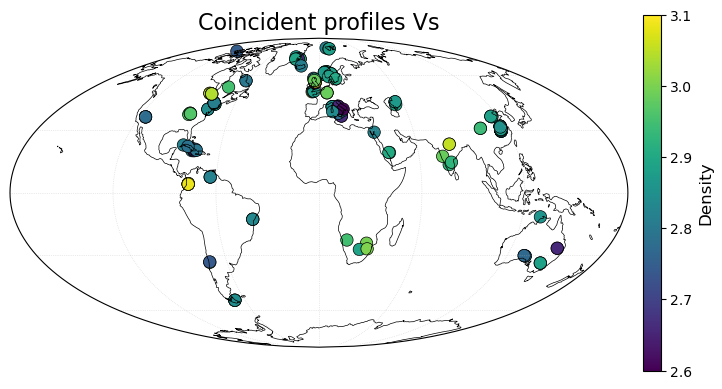

In [31]:
# Locations of coincident profiles (Vp density)
lon, lat = lon_lat[:,0], lon_lat[:,1]
color = rho_rho[:,0]

smplt.plot_geographic_locations(lon, lat, color, projection='Mollweide', 
                         title='Coincident profiles Vp', 
                         third_field_label='Density',
                         colorbar_range=[2.6, 3.1])

# Locations of coincident profiles (Vs density)
color = rho_rho[:,1]
smplt.plot_geographic_locations(lon, lat, color, projection='Mollweide', 
                         title='Coincident profiles Vs', 
                         third_field_label='Density',
                         colorbar_range=[2.6, 3.1])


We can now plot scatter crossplots of $V_P$ and aginst $V_S$, densities and moho depths.  The red lines in the plots represent the best-fitting orthogonal-distance regression line.  ODR regression assues errors are present in both $x$ and $y$ coordinates.

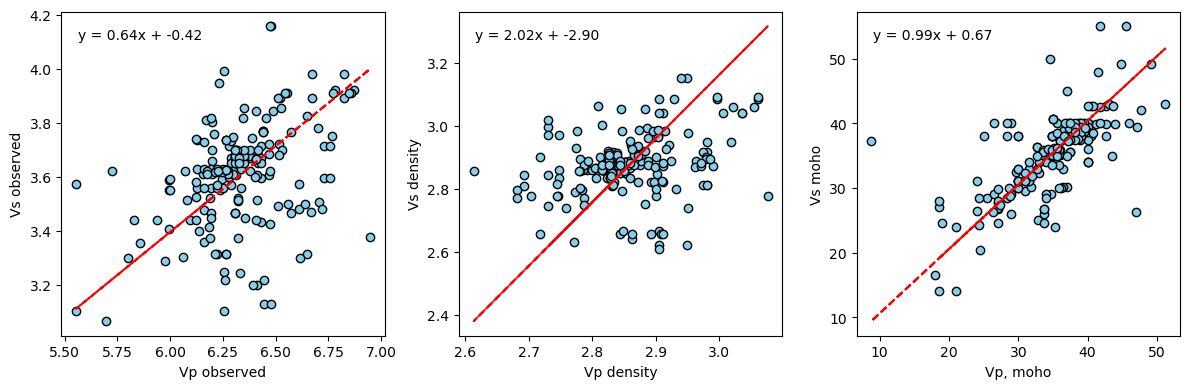

In [32]:
smplt.plot_three_scatter(vp_vs_vpcalc[:, :2], 
                   rho_rho, moho_moho, 
                   x_labels=["Vp observed", "Vp density", "Vp, moho"], 
                   y_labels=["Vs observed", "Vs density", "Vs moho"])